In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import os
import numpy as np
from PIL import Image
from tqdm import tqdm
import random

c:\Users\user\anaconda3\envs\summarizerP39\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [27]:
image_res = 256
image_center_x = 0
image_center_y = 0
zoom_factor = 1
num_classes = 2
init_center = 0
init_range = 1

width = 64

In [3]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(2 + num_classes, width)
        self.fc2 = nn.Linear(width, width)
        self.fc3 = nn.Linear(width, width)
        self.fc4 = nn.Linear(width, width)
        self.fc5 = nn.Linear(width, width)
        self.fc6 = nn.Linear(width, 3)
        
        nn.init.uniform_(self.fc1.weight, a=init_center - init_range, b=init_center + init_range)
        nn.init.uniform_(self.fc2.weight, a=init_center - init_range, b=init_center + init_range)
        nn.init.uniform_(self.fc3.weight, a=init_center - init_range, b=init_center + init_range)
        nn.init.uniform_(self.fc4.weight, a=init_center - init_range, b=init_center + init_range)
        nn.init.uniform_(self.fc5.weight, a=init_center - init_range, b=init_center + init_range)
        nn.init.uniform_(self.fc6.weight, a=init_center - init_range, b=init_center + init_range)

    def forward(self, x):
        x = torch.tanh(self.fc1(x))
        x = torch.tanh(self.fc2(x))
        x = torch.tanh(self.fc3(x))
        x = torch.tanh(self.fc4(x))
        x = torch.tanh(self.fc5(x))
        x = torch.sigmoid(self.fc6(x))
        
        return x

net = Net()
GPU = torch.device("cuda")
net.to(GPU)

Net(
  (fc1): Linear(in_features=4, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=64, bias=True)
  (fc4): Linear(in_features=64, out_features=64, bias=True)
  (fc5): Linear(in_features=64, out_features=64, bias=True)
  (fc6): Linear(in_features=64, out_features=3, bias=True)
)

In [5]:
loss = nn.BCELoss()
optimizer = optim.AdamW(net.parameters(), lr=0.0001)

In [6]:
def load_image(image_path):
    img = Image.open(image_path)
    img = img.resize((image_res, image_res))
    img = img.convert("RGB")
    img_array = np.array(img) / 255

    return img_array

In [7]:
def display_image(img_array):
    img_array = np.array(img_array)
    plt.imshow(img_array)
    plt.show()

In [8]:
def train_nn(question_tensor, answer_tensor, model, loss=loss, optimizer=optimizer):
    optimizer.zero_grad()
    outputs = model(question_tensor)
    loss = loss(outputs, answer_tensor)
    loss.backward()
    optimizer.step()

In [9]:
def get_img_array(class_tensor):
    coords = torch.meshgrid((torch.arange(image_res, dtype=torch.float32, device=GPU) / image_res - 0.5 - image_center_y) * zoom_factor,
                            (torch.arange(image_res, dtype=torch.float32, device=GPU) / image_res - 0.5 + image_center_x) * zoom_factor)
    
    coords = torch.stack(coords, dim=-1)
    
    with_class = torch.zeros(image_res, image_res, 2 + num_classes, dtype=torch.float32, device=GPU)
    
    with_class[:, :, num_classes:] = class_tensor.repeat(image_res, image_res, 1)
    with_class[:, :, :num_classes] = coords
    
    image = net(with_class)
    return image

In [11]:
directory1 = r"C:\Users\user\Desktop\learning from human\images\strawberry"
directory2 = r"C:\Users\user\Desktop\learning from human\images\banana"
files1 = os.listdir(directory1)
files2 = os.listdir(directory2)
class_tensor1 = torch.tensor([1, 0], dtype=torch.float32, device=GPU)
class_tensor2 = torch.tensor([0, 1], dtype=torch.float32, device=GPU)

questions = []
answers = []

for x in tqdm(range(len(files1))):
    img1 = torch.tensor(load_image(fr"{directory1}\{files1[x]}"), dtype=torch.float32, device=GPU)
    img2 = torch.tensor(load_image(fr"{directory2}\{files2[x]}"), dtype=torch.float32, device=GPU)
    
    for y_cord in range(len(img1)):
        for x_cord in range(len(img1)):
            questions.append(torch.cat((torch.tensor((y_cord / image_res - 0.5, x_cord / image_res - 0.5), dtype=torch.float32, device=GPU), class_tensor1)))
            answers.append(img1[y_cord][x_cord])
    
    for y_cord in range(len(img2)):
        for x_cord in range(len(img2)):
            questions.append(torch.cat((torch.tensor((y_cord / image_res - 0.5, x_cord / image_res - 0.5), dtype=torch.float32, device=GPU), class_tensor2)))
            answers.append(img2[y_cord][x_cord])
    
    for y_cord in range(len(img1)):
        for x_cord in range(len(img1)):
            questions.append(torch.cat((torch.tensor((y_cord / image_res - 0.5, x_cord / image_res - 0.5), dtype=torch.float32, device=GPU), class_tensor1 + class_tensor2)))
            answers.append(img1[y_cord][x_cord] + img2[y_cord][x_cord])

combined_lists = list(zip(questions, answers))
random.shuffle(combined_lists)
questions, answers = zip(*combined_lists)

100%|██████████| 10/10 [00:03<00:00,  2.54it/s]


In [12]:
for y in tqdm(range(5)):
    for x in (range(len(questions))):
        train_nn(questions[x], answers[x], net)

100%|██████████| 5/5 [05:01<00:00, 60.37s/it]


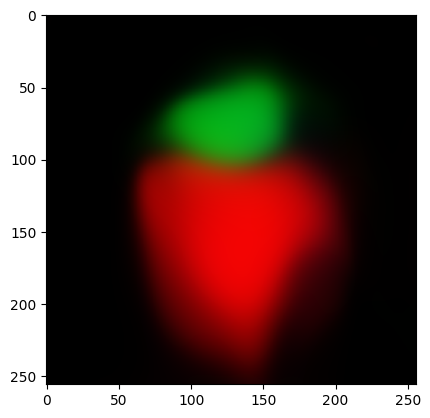

In [19]:
# strawberry
display_image(get_img_array(torch.tensor([1, 0], dtype=torch.float32, device=GPU)).detach().cpu())

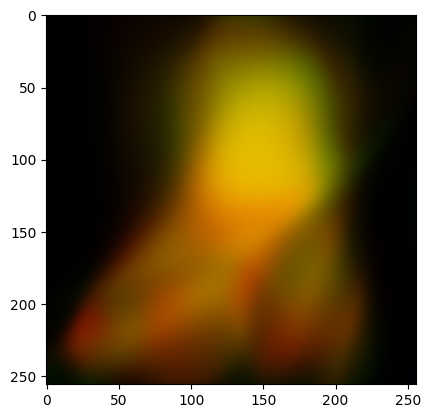

In [20]:
# banana
display_image(get_img_array(torch.tensor([0, 1], dtype=torch.float32, device=GPU)).detach().cpu())

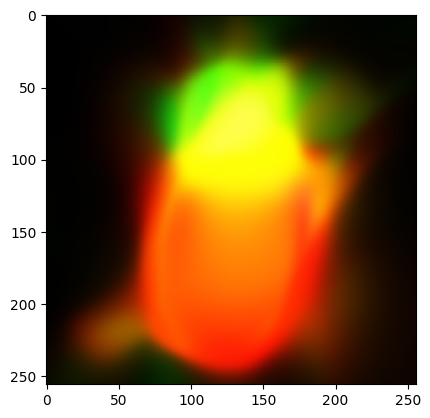

In [22]:
# both
display_image(get_img_array(torch.tensor([1, 1], dtype=torch.float32, device=GPU)).detach().cpu())

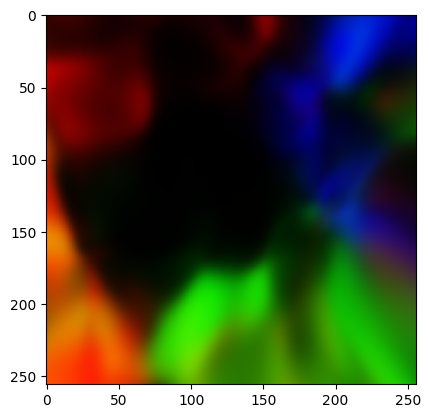

In [23]:
# none
display_image(get_img_array(torch.tensor([0, 0], dtype=torch.float32, device=GPU)).detach().cpu())

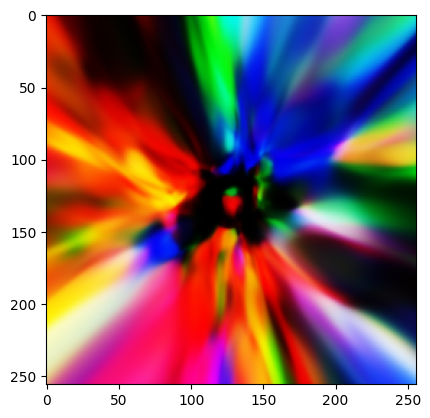

In [26]:
# strawberry zoomed out
display_image(get_img_array(torch.tensor([1, 0], dtype=torch.float32, device=GPU)).detach().cpu())